In [3]:
#from https://github.com/logicalguess/tf-idf-spark-and-python/blob/master/src/main/python/main.py
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

from KaggleWord2VecUtility import KaggleWord2VecUtility

train_file = 'labeledTrainData.tsv'
unlabeled_train_file = 'unlabeledTrainData.tsv'
test_file = 'testData.tsv'
#output_file = 'data/submit_200_4.csv'

train = pd.read_csv( train_file, header = 0, delimiter = "\t", quoting = 3 )
test = pd.read_csv( test_file, header = 0, delimiter = "\t", quoting = 3 )
unlabeled_train = pd.read_csv( unlabeled_train_file, header = 0, delimiter= "\t", quoting = 3 )

print("Parsing train reviews...")

clean_train_reviews = []
for review in train['review']:
    clean_train_reviews.append( " ".join( KaggleWord2VecUtility.review_to_wordlist( review )))

unlabeled_clean_train_reviews = []
for review in unlabeled_train['review']:
    unlabeled_clean_train_reviews.append( " ".join( KaggleWord2VecUtility.review_to_wordlist( review )))

print("Parsing test reviews...")

clean_test_reviews = []
for review in test['review']:
    clean_test_reviews.append( " ".join( KaggleWord2VecUtility.review_to_wordlist( review )))

print("Vectorizing...")

vectorizer = TfidfVectorizer( min_df=2, max_df=0.95, max_features = 200000, ngram_range = ( 1, 4 ),
                              sublinear_tf = True )

vectorizer = vectorizer.fit(clean_train_reviews + unlabeled_clean_train_reviews)
train_data_features = vectorizer.transform( clean_train_reviews )
test_data_features = vectorizer.transform( clean_test_reviews )

print("Reducing dimension...")

from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif
fselect = SelectKBest(chi2 , k=70000)
train_data_features = fselect.fit_transform(train_data_features, train["sentiment"])
test_data_features = fselect.transform(test_data_features)

print("Training...")

model1 = MultinomialNB(alpha=0.0005)
model1.fit( train_data_features, train["sentiment"] )

model2 = SGDClassifier(loss='modified_huber', n_iter=5, random_state=0, shuffle=True)
model2.fit( train_data_features, train["sentiment"] )

p1 = model1.predict_proba( test_data_features )[:,1]
p2 = model2.predict_proba( test_data_features )[:,1]
'''
print "Writing results..."

output = pd.DataFrame( data = { "id": test["id"], "sentiment": .2*p1 + 1.*p2 } )
output.to_csv( output_file, index = False, quoting = 3 )
'''

Parsing train reviews...


/program/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /program/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


Parsing test reviews...
Vectorizing...
Reducing dimension...
Training...


'\nprint "Writing results..."\n\noutput = pd.DataFrame( data = { "id": test["id"], "sentiment": .2*p1 + 1.*p2 } )\noutput.to_csv( output_file, index = False, quoting = 3 )\n'

In [4]:
p=0.2*p1+1.*p2

In [5]:
res=lambda x: 1 if x>0.5 else 0
res1=list(map(res, p))

In [6]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [9]:
test['score']=test.id.apply(lambda x: int(x.strip('""').split('_')[1]))

In [10]:
test['sentiment']=test['score'].map(lambda x: int(x>5))

In [11]:
test.head()

,id,review,score,sentiment
0,"""12311_10""","""Naturally in a film who's main themes are of ...",10,1
1,"""8348_2""","""This movie is a disaster within a disaster fi...",2,0
2,"""5828_4""","""All in all, this is a movie for kids. We saw ...",4,0
3,"""7186_2""","""Afraid of the Dark left me with the impressio...",2,0
4,"""12128_7""","""A very accurate depiction of small time mob l...",7,1


In [12]:
print(sum(res1 & test["sentiment"]) / len(test["sentiment"]))

0.47804


In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test['sentiment'],p)

0.96904381439999987

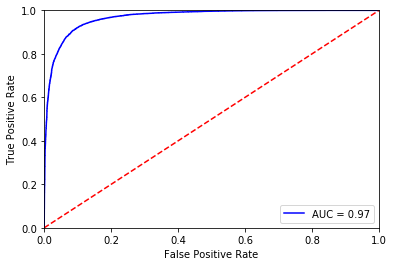

In [46]:
#plot auc curve
from matplotlib import pyplot as plt
from sklearn import metrics
fpr, tpr, threshold= metrics.roc_curve(test['sentiment'],p)
roc_auc=metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [56]:
def find_optimal_cutoff(target, predicted):
    fpr, tpr, threshold=metrics.roc_curve(target, predicted)
    i=range(len(tpr))
    roc=pd.DataFrame({'tf': pd.Series(tpr-(1-fpr), index=i), 'threshold':pd.Series(threshold, index=i)})
    roc_t=roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])
find_optimal_cutoff(test['sentiment'], p)

[0.61845962472111271]

In [23]:
from sklearn.metrics import accuracy_score
import numpy as np
accuracy_score(test['sentiment'],np.round(p))

0.89707999999999999

In [22]:
import numpy as np
np.round(p)

array([ 1.,  0.,  1., ...,  0.,  1.,  1.])

In [21]:
import numpy as np
np.round([0.01])

array([ 0.])

In [25]:
'what is'.split()

['what', 'is']

In [38]:
from nltk.corpus import words
from nltk import PorterStemmer
stemmer=PorterStemmer()
stemmer.stem('pricing')

'price'

In [40]:
'download' in words.words()

False

In [35]:
wordsList=[stemmer.stem(w) for w in words.words()]

In [36]:
'' in wordsList

True

In [41]:
inp=[{'a':1, 'b':2}, {'a':3, 'b':4}]
import pandas as pd
df=pd.DataFrame(inp)

In [42]:
for index, row in df.iterrows():
    print(type(row))
    print(row)

<class 'pandas.core.series.Series'>
a    1
b    2
Name: 0, dtype: int64
<class 'pandas.core.series.Series'>
a    3
b    4
Name: 1, dtype: int64


In [43]:
df

,a,b
0,1,2
1,3,4
